## Step-by-Step implementation of Region-CNN using Tenorflow with Keras fit function
Here, the airplane dataset is used to detect the airplanes from the remote sensing images. The dataset is available in the following link http://www.escience.cn/people/JunweiHan/NWPU-RESISC45.html. 

Patches are extracted using Selective Search algorithm based on intersection of Union (IoU) value and saved as .npy format. Later, the .npy file is loaded and splitted into train and validation dataset. The fine tuned VGG16 model has been trained using keras fit function

### Import the libraries

In [1]:
import os
import cv2
import keras
from keras.layers import Dense
from keras import Model
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf

Using TensorFlow backend.


### Set path of image and annotation directory

In [2]:
image_path = os.path.join(os.getcwd(), "airplanes/images")
annotation_path = os.path.join(os.getcwd(), "airplanes/annotations")

### Display image with annotation (ground truth boundary boxes)

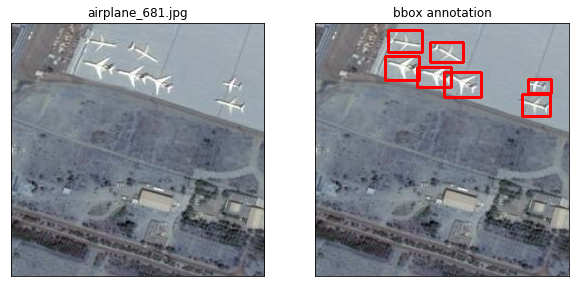

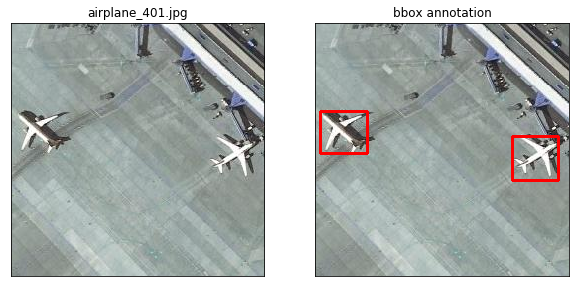

In [3]:
for i in range(2):
    fig = plt.figure(figsize=(10,8))
    idx = np.random.choice(os.listdir(annotation_path))

    img_file = idx.split(".")[0] + ".jpg"
    img = cv2.imread(os.path.join(image_path, img_file))
    annotation = pd.read_csv(os.path.join(annotation_path, idx))
    fig.add_subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(img_file), plt.xticks([]), plt.yticks([])
    for row in annotation.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2) # (x1,y1) -> start point and (x2,y2) -> end pint of the bbox
    fig.add_subplot(1, 2, 2)
    plt.imshow(img)
    plt.title("bbox annotation"), plt.xticks([]), plt.yticks([])

### Region detection using selective searches and display the regions

In [4]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

(Text(0.5, 1.0, '718 regions detected'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

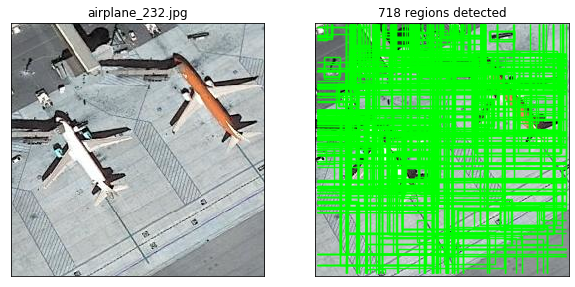

In [5]:
img_file = np.random.choice(os.listdir(image_path))
img = cv2.imread(os.path.join(image_path, img_file))
ss.setBaseImage(img)
ss.switchToSelectiveSearchFast()
regions = ss.process()

fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1,2,1)
plt.imshow(img)
plt.title(img_file), plt.xticks([]), plt.yticks([])

for i, region in enumerate(regions):
    x, y, w, h = region
    cv2.rectangle(img, (x,y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
fig.add_subplot(1,2,2)
plt.imshow(img)
title = str(len(regions)) + " regions detected"
plt.title(title), plt.xticks([]), plt.yticks([])

### Patch extraction using selective search and save as .npy format
Patch extraction is needed only for the first time. Do not run this section if you run this program second time

#### Define the function to caculate the Intersection of Union (IoU)

In [ ]:
def get_iou(bbox1, bbox2):   
    x_left = max(bbox1['x1'], bbox2['x1'])
    y_top = max(bbox1['y1'], bbox2['y1'])
    x_right = min(bbox1['x2'], bbox2['x2'])
    y_bottom = min(bbox1['y2'], bbox2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    bbox1_area = (bbox1['x2'] - bbox1['x1']) * (bbox1['y2'] - bbox1['y1'])
    bbox2_area = (bbox2['x2'] - bbox2['x1']) * (bbox2['y2'] - bbox2['y1'])
    
    iou = intersection_area / float(bbox1_area + bbox2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

#### Extract patches and append to images and labels list

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
from tqdm import tqdm

train_images = []
train_labels = []

for e,i in enumerate(tqdm(os.listdir(annotation_path))):
    img_file = i.split(".")[0] + '.jpg'
    #print(e, img_file)
    img = cv2.imread(os.path.join(image_path, img_file))
    annotation = pd.read_csv(os.path.join(annotation_path, i))
    gtbboxes = []

    for row in annotation.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtbboxes.append({'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2})

    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    regions = ss.process() # return region as (x,y,width and height) form

    counter = 0
    falsecounter = 0

    temp_img = img.copy()
    for e, region in enumerate(regions):
        if e < 2000:
            for gtbbox in gtbboxes:
                x,y,w,h = region 
                iou = get_iou(gtbbox, {'x1':x, 'y1':y, 'x2':x+w, 'y2':y+h})
                if counter < 30:
                    if iou > 0.70:
                        cropped_img = temp_img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
                        train_images.append(resized_img)
                        train_labels.append(1)
                        counter += 1

                if falsecounter < 30:
                    if iou < 0.3 :
                        cropped_img = temp_img[y:y+h, x:x+w]
                        resized_img = cv2.resize(cropped_img, (224, 224), interpolation=cv2.INTER_AREA)
                        train_images.append(resized_img)
                        train_labels.append(0)
                        falsecounter += 1

#### Covert the train_images and train_labels list to numpy array

In [ ]:
x_train = np.array(train_images)
y_train = np.array(train_labels)

#### Save the numpy array to .npy format for future use (No need to extract the patches each time)

In [ ]:
np.save('x_train_npy.npy', x_train)
np.save('y_train_npy.npy', y_train)
print('Data saved to %s as .npy format !!' %(os.getcwd()))

### Load the .npy file

In [6]:
x_train_npy = np.load('x_train_npy.npy')
y_train_npy = np.load('y_train_npy.npy')
print(x_train_npy.shape)
print(y_train_npy.shape)

(30229, 224, 224, 3)
(30229,)


### Create small dataset if needed

In [7]:
skip = 2 # it wil skip evey two element
x_train_toy = x_train_npy[::skip]
y_train_toy = y_train_npy[::skip]
print(x_train_toy.shape)
print(y_train_toy.shape)

(15115, 224, 224, 3)
(15115,)


### Level binarizer

In [8]:
from sklearn.preprocessing import LabelBinarizer

In [9]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [11]:
lenc = MyLabelBinarizer()
y_train_bin =  lenc.fit_transform(y_train_toy)
print(y_train_bin[15])

[0 1]


### Split the dataset into train and test set

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_toy, y_train_bin, 
                                                    test_size=0.10)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(13603, 224, 224, 3) (1512, 224, 224, 3) (13603, 2) (1512, 2)


### Develop the model

#### Laod the VGG16 model

In [13]:
vggmodel = VGG16(weights='imagenet', include_top=True)
#vggmodel.summary()

#### Fine tune the model

In [14]:
# Freeze the first 15 layers
for layers in (vggmodel.layers)[:15]:
    #print(layers)
    layers.trainable = False

# Remove the last layers and change to class 2 instead of 1000
X = vggmodel.layers[-2].output
predictions = Dense(2, activation='softmax')(X)
model = Model(input=vggmodel.input, output=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

C:\Users\Fashiar\Anaconda3\envs\mycoco\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


### Compile the model

In [15]:
lr = 0.0001
#decay = 1e-6
#momentum=0.9
model.compile(loss=keras.losses.categorical_crossentropy,
                   optimizer=Adam(lr=lr),
                   metrics=['accuracy'])

### Set model check point

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("region_cnn_v2.h5", monitor='val_loss',
                             verbose=1, save_best_only=True,
                             save_weights_only=False, mode='auto',
                             period=1)
early = EarlyStopping(monitor='val_loss',
                      min_delta=0,
                      patience=100,
                      verbose=1,
                      mode='auto')

### Train the model

#### Calculate the class_weight

In [17]:
# Need the class_weight to train the unbalanced datasets
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

{0: 1.6306641093263006, 1: 0.7211089906700594}


In [18]:
batch_size = 10
epochs = 20
fitted_model = model.fit(x_train, y_train,
                         batch_size=10,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test),
                         shuffle=True,
                         class_weight=d_class_weights,
                         callbacks=[checkpoint, early])

Train on 13603 samples, validate on 1512 samples
Epoch 1/20
13603/13603 [==============================] - 157s 12ms/step - loss: 0.2693 - acc: 0.9143 - val_loss: 0.1865 - val_acc: 0.9319

Epoch 00001: val_loss improved from inf to 0.18647, saving model to region_cnn_v2.h5
Epoch 2/20
13603/13603 [==============================] - 139s 10ms/step - loss: 0.1652 - acc: 0.9438 - val_loss: 0.1518 - val_acc: 0.9577

Epoch 00002: val_loss improved from 0.18647 to 0.15184, saving model to region_cnn_v2.h5
Epoch 3/20
13603/13603 [==============================] - 138s 10ms/step - loss: 0.1438 - acc: 0.9485 - val_loss: 0.1397 - val_acc: 0.9530

Epoch 00003: val_loss improved from 0.15184 to 0.13967, saving model to region_cnn_v2.h5
Epoch 4/20
13603/13603 [==============================] - 139s 10ms/step - loss: 0.1428 - acc: 0.9508 - val_loss: 0.1321 - val_acc: 0.9590

Epoch 00004: val_loss improved from 0.13967 to 0.13208, saving model to region_cnn_v2.h5
Epoch 5/20
13603/13603 [===============

### Display the accuracy and loss graph

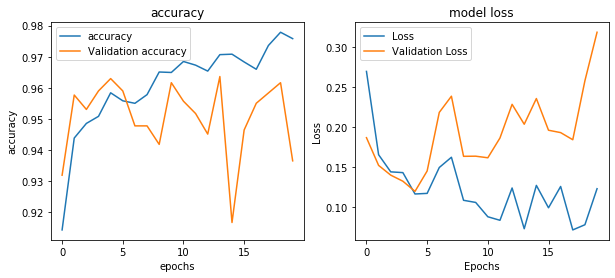

In [19]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(fitted_model.history["acc"])
plt.plot(fitted_model.history['val_acc'])
plt.title("accuracy"), plt.ylabel("accuracy"), plt.xlabel("epochs")
plt.legend(["accuracy","Validation accuracy"])

fig.add_subplot(1,2,2)
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title("model loss"), plt.ylabel("Loss"), plt.xlabel("Epochs")
plt.legend(["Loss","Validation Loss"])
#plt.show()
#plt.savefig('chart loss.png')

### Prediction of some patches

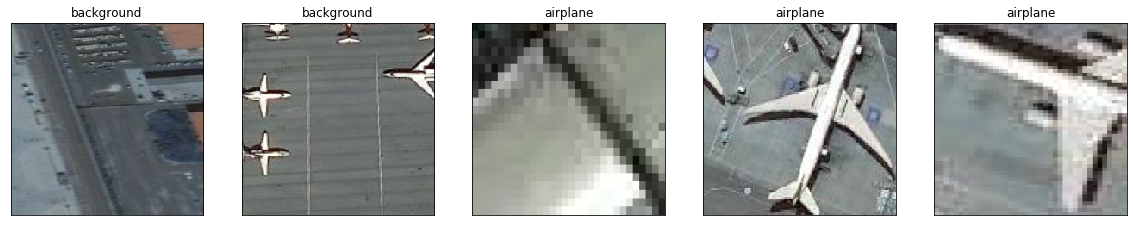

In [20]:
rows = 1
cols = 5
img_files = np.random.randint(0, len(x_test), rows*cols)

fig = plt.figure(figsize=(20,20))
for i, file in enumerate(img_files):
    img = x_test[file]
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img)
    img = np.expand_dims(img, axis=0)
    out= model.predict(img)
    if out[0][0] > out[0][1]:
        plt.title("airplane")
    else:
        plt.title("background")
    plt.xticks([]), plt.yticks([])

### Display the airplane detection results

In [21]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

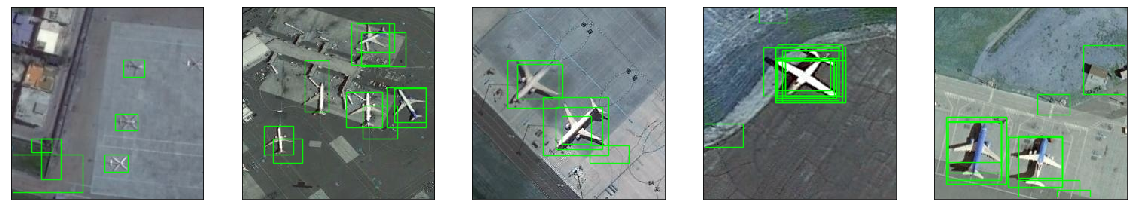

In [23]:
rows = 1
cols = 5
img_files = np.random.choice(os.listdir(image_path), rows*cols)

fig = plt.figure(figsize=(20, 20))

for i, file in enumerate(img_files):
    img = cv2.imread(os.path.join(image_path,file))
    ss.setBaseImage(img)
    ss.switchToSelectiveSearchFast()
    regions = ss.process()
    imout = img.copy()
    for e,region in enumerate(regions):
        if e < 2000:
            x,y,w,h = region
            timage = imout[y:y+h,x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out= model.predict(img)
            if out[0][0] > 0.9:
                cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(imout)
    plt.xticks([]), plt.yticks([])